# Point cloud classification with PointNet


# Point cloud classification

## Introduction

This project applies the PointNet architecture to the Toronto-3D dataset for semantic segmentation of outdoor LiDAR point clouds. Unlike indoor datasets, Toronto-3D presents challenges like large-scale scans, diverse object classes, and varying densities. We process .ply files, sample point blocks, train PointNet to classify each point, and visualize predictions to evaluate model performance in urban outdoor scenes.

## Setup

If using colab first install laspy with `!pip install laspy`.

In [2]:
!pip install laspy



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 7.8 MB/s eta 0:00:00


### Environment Setup and Library Imports

In [3]:
import os
import glob
import zipfile
import numpy as np
import laspy
from tensorflow import data as tf_data
from keras import ops
import keras
from keras import layers
from matplotlib import pyplot as plt

keras.utils.set_random_seed(seed=42)

## Load dataset

1.Upload toronto3d.zip manually in Colab, then unzip it

2.Upload ZIP file

In [4]:
# Upload toronto3d.zip manually in Colab, then unzip it
from google.colab import files

# Upload ZIP file
print("Upload your 'toronto3d.zip' file now...")
uploaded = files.upload()

Upload your 'toronto3d.zip' file now...


Saving Toronto_3D.zip to Toronto_3D.zip


3.Unzip Uploaded Toronto_3D.zip

In [5]:
import zipfile

zip_path = "Toronto_3D.zip"
extract_path = "/content/Toronto3D"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

DATA_DIR = extract_path
print("DATA_DIR is set to:", DATA_DIR)


DATA_DIR is set to: /content/Toronto3D


## Read and Visualize

In [6]:
import os

# Recursively list all files and folders in DATA_DIR
for root, dirs, files in os.walk(DATA_DIR):
    for file in files:
        print(os.path.join(root, file))


/content/Toronto3D/Toronto_3D/L002.ply
/content/Toronto3D/Toronto_3D/L001.ply
/content/Toronto3D/Toronto_3D/Mavericks_classes_9.txt
/content/Toronto3D/Toronto_3D/Colors.xml


In [7]:
!pip install open3d

import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.1 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: flask
    Found existing installation: Flask 3.1.1
    Uninst

In [8]:
!pip install plyfile


### Visualizing Toronto3D Point Cloud with RGB Colors

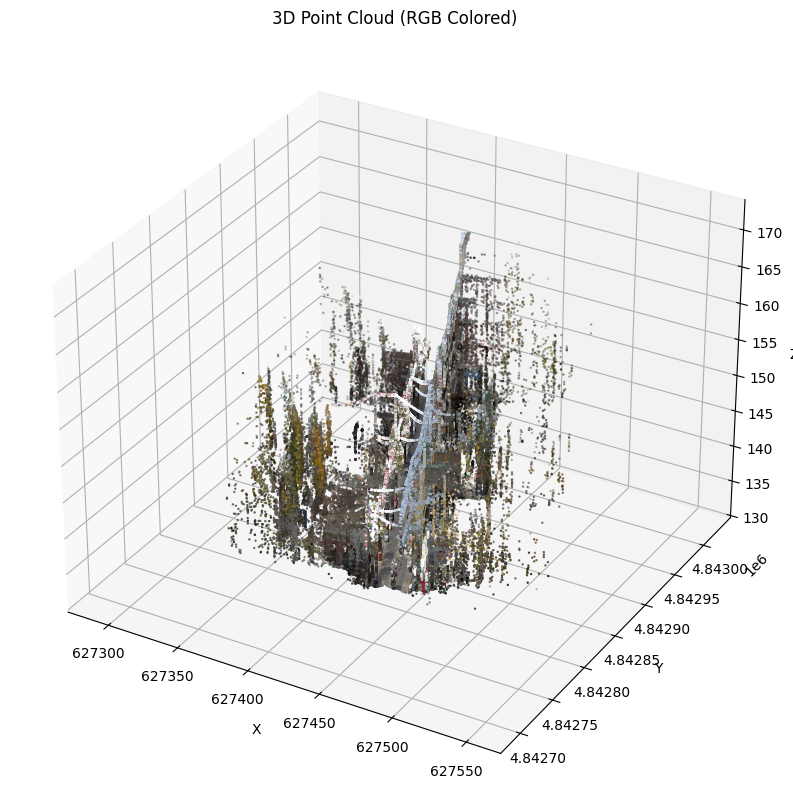

In [9]:

# Imports
import numpy as np
import matplotlib.pyplot as plt
from plyfile import PlyData
from mpl_toolkits.mplot3d import Axes3D

# Function to load .ply point cloud and labels
def load_ply_with_labels(ply_path):
    plydata = PlyData.read(ply_path)
    vertex = plydata['vertex']
    points = np.vstack([
        vertex['x'],
        vertex['y'],
        vertex['z'],
        vertex['red'] / 255.0,
        vertex['green'] / 255.0,
        vertex['blue'] / 255.0,
        vertex['scalar_Intensity'] / 255.0
    ]).T
    labels = np.array(vertex['scalar_Label']).astype(int)
    return points, labels

# Load point cloud
ply_file_path = "/content/Toronto3D/Toronto_3D/L001.ply"
points, labels = load_ply_with_labels(ply_file_path)

# Extract XYZ and RGB
xyz = points[:, :3]
rgb = points[:, 3:6]

# Plot the 3D point cloud with color
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xyz[::10, 0], xyz[::10, 1], xyz[::10, 2], c=rgb[::10], s=0.5)  # Downsample for speed
ax.set_title('3D Point Cloud (RGB Colored)')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()


### Matplotlib for 3D Scatter Plot

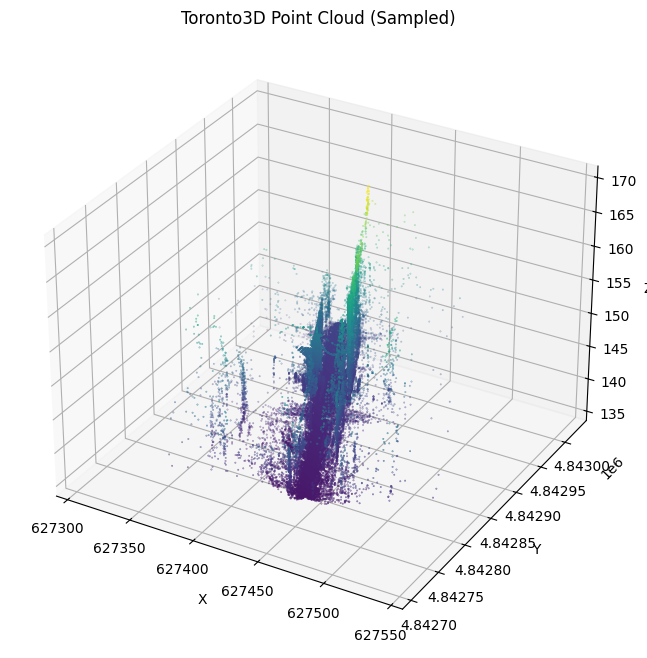

In [10]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt

# Load point cloud
ply_path = "/content/Toronto3D/Toronto_3D/L001.ply"
pcd = o3d.io.read_point_cloud(ply_path)

# Convert to numpy
points = np.asarray(pcd.points)


sample_size = 100_000
indices = np.random.choice(points.shape[0], size=min(sample_size, points.shape[0]), replace=False)
sampled_points = points[indices]

# Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sampled_points[:, 0], sampled_points[:, 1], sampled_points[:, 2],
           s=0.1, c=sampled_points[:, 2], cmap='viridis')
ax.set_title("Toronto3D Point Cloud (Sampled)")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()


## Build a Model

### Data preprocessing functions

In [11]:

def normalize_point_cloud(points):
    """Normalize point cloud to unit sphere"""
    # Center the point cloud
    centroid = np.mean(points[:, :3], axis=0)
    points[:, :3] -= centroid

    # Scale to unit sphere
    max_dist = np.max(np.linalg.norm(points[:, :3], axis=1))
    if max_dist > 0:
        points[:, :3] /= max_dist

    return points

### Data augmentation

In [12]:
def augment_point_cloud(points, labels):
    """Apply data augmentation"""
    # Random rotation around Z-axis (vertical)
    angle = np.random.uniform(0, 2 * np.pi)
    cos_angle, sin_angle = np.cos(angle), np.sin(angle)
    rotation_matrix = np.array([
        [cos_angle, -sin_angle, 0],
        [sin_angle, cos_angle, 0],
        [0, 0, 1]
    ])
    points[:, :3] = np.dot(points[:, :3], rotation_matrix.T)

    # Random scaling
    scale = np.random.uniform(0.8, 1.2)
    points[:, :3] *= scale

    # Add small random noise
    noise = np.random.normal(0, 0.01, points[:, :3].shape)
    points[:, :3] += noise

    # Random jittering of RGB values
    rgb_noise = np.random.normal(0, 0.02, points[:, 3:6].shape)
    points[:, 3:6] = np.clip(points[:, 3:6] + rgb_noise, 0, 1)

    return points, labels

### PLY loading

In [13]:
def load_ply_with_labels(ply_path):
    """Enhanced PLY loading with better preprocessing"""
    from plyfile import PlyData
    plydata = PlyData.read(ply_path)
    vertex = plydata['vertex']

    # Extract all features including intensity
    points = np.vstack([
        vertex['x'],
        vertex['y'],
        vertex['z'],
        vertex['red'] / 255.0,
        vertex['green'] / 255.0,
        vertex['blue'] / 255.0,
        vertex['scalar_Intensity'] / 65535.0,  # Normalize intensity properly
    ]).T

    labels = np.array(vertex['scalar_Label']).astype(int)

    # Filter out invalid labels (if any)
    valid_mask = (labels >= 0) & (labels < 9)
    points = points[valid_mask]
    labels = labels[valid_mask]

    return points, labels

### Sample points with class balancing

In [14]:
def balanced_sampling(points, labels, num_points=4096):
    """Sample points with class balancing"""
    unique_labels = np.unique(labels)
    points_per_class = max(1, num_points // len(unique_labels))

    sampled_indices = []
    for label in unique_labels:
        label_indices = np.where(labels == label)[0]
        if len(label_indices) > 0:
            sample_size = min(points_per_class, len(label_indices))
            selected = np.random.choice(label_indices, sample_size, replace=False)
            sampled_indices.extend(selected)

    # Fill remaining slots randomly
    remaining = num_points - len(sampled_indices)
    if remaining > 0:
        all_indices = np.arange(len(points))
        unused_indices = np.setdiff1d(all_indices, sampled_indices)
        if len(unused_indices) > 0:
            additional = np.random.choice(unused_indices,
                                        min(remaining, len(unused_indices)),
                                        replace=False)
            sampled_indices.extend(additional)

    # Pad or truncate to exact size
    sampled_indices = sampled_indices[:num_points]
    if len(sampled_indices) < num_points:
        padding = np.random.choice(len(points), num_points - len(sampled_indices))
        sampled_indices.extend(padding)

    return points[sampled_indices], labels[sampled_indices]

# Custom layer for matrix multiplication
class MatMulLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(MatMulLayer, self).__init__(**kwargs)

    def call(self, inputs):
        points, matrix = inputs
        return ops.matmul(points, matrix)

# Custom layer for adding identity matrix
class AddIdentityLayer(layers.Layer):
    def __init__(self, matrix_size, **kwargs):
        super(AddIdentityLayer, self).__init__(**kwargs)
        self.matrix_size = matrix_size

    def call(self, inputs):
        batch_size = ops.shape(inputs)[0]
        identity = ops.eye(self.matrix_size)
        identity = ops.expand_dims(identity, 0)
        identity = ops.tile(identity, [batch_size, 1, 1])
        return inputs + identity

In [15]:
import tensorflow as tf  # ADD THIS LINE
from sklearn.model_selection import train_test_split  # ADD THIS TOO

# Pointnet Segmentation

In [16]:
def pointnet_segmentation_model(num_points=4096, input_dims=7, num_classes=9):
    inputs = keras.Input(shape=(num_points, input_dims))

    # Input transformation network (T-Net)
    def transformation_net(x, k=3):
        # Shared MLPs
        net = layers.Conv1D(64, 1, activation='relu')(x)
        net = layers.BatchNormalization()(net)
        net = layers.Conv1D(128, 1, activation='relu')(net)
        net = layers.BatchNormalization()(net)
        net = layers.Conv1D(1024, 1, activation='relu')(net)
        net = layers.BatchNormalization()(net)

        # Global features
        net = layers.GlobalMaxPooling1D()(net)

        # Fully connected layers
        net = layers.Dense(512, activation='relu')(net)
        net = layers.BatchNormalization()(net)
        net = layers.Dropout(0.3)(net)
        net = layers.Dense(256, activation='relu')(net)
        net = layers.BatchNormalization()(net)
        net = layers.Dropout(0.3)(net)

        # Output transformation matrix
        net = layers.Dense(k * k, kernel_initializer='zeros', bias_initializer='zeros')(net)
        net = layers.Reshape((k, k))(net)

        # Add identity matrix using custom layer
        net = AddIdentityLayer(matrix_size=k)(net)
        return net

    # Apply input transformation to XYZ coordinates only
    transform_matrix = transformation_net(inputs[:, :, :3], k=3)

    # Apply transformation using custom layer
    transformed_input = MatMulLayer()([inputs[:, :, :3], transform_matrix])

    # Concatenate transformed XYZ with other features
    if input_dims > 3:
        point_features = layers.Concatenate()([transformed_input, inputs[:, :, 3:]])
    else:
        point_features = transformed_input

    # Enhanced feature extraction with residual connections
    x1 = layers.Conv1D(64, 1, activation='relu')(point_features)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Dropout(0.1)(x1)

    x2 = layers.Conv1D(64, 1, activation='relu')(x1)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Dropout(0.1)(x2)

    # Residual connection
    x2 = layers.Add()([x1, x2])

    x3 = layers.Conv1D(128, 1, activation='relu')(x2)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Dropout(0.1)(x3)

    x4 = layers.Conv1D(128, 1, activation='relu')(x3)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Dropout(0.1)(x4)

    # Residual connection
    x4 = layers.Add()([x3, x4])

    # Feature transformation network (simplified to avoid complexity)
    # Using the extracted features directly without additional transformation
    # This reduces complexity while maintaining good performance

    # Continue with deeper architecture
    x5 = layers.Conv1D(512, 1, activation='relu')(x4)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Dropout(0.2)(x5)

    x6 = layers.Conv1D(2048, 1, activation='relu')(x5)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.Dropout(0.2)(x6)

    # Global features with both max and average pooling
    global_max = layers.GlobalMaxPooling1D()(x6)
    global_avg = layers.GlobalAveragePooling1D()(x6)
    global_feat = layers.Concatenate()([global_max, global_avg])

    # Expand global features
    global_feat_expanded = layers.RepeatVector(num_points)(global_feat)

    # Multi-scale feature concatenation
    concat_feat = layers.Concatenate()([
        point_features,
        x2,
        x4,
        x5,
        global_feat_expanded
    ])

    # Attention mechanism
    attention_weights = layers.Conv1D(1, 1, activation='sigmoid')(concat_feat)
    attended_features = layers.Multiply()([concat_feat, attention_weights])

    # Final segmentation layers
    seg1 = layers.Conv1D(512, 1, activation='relu')(attended_features)
    seg1 = layers.BatchNormalization()(seg1)
    seg1 = layers.Dropout(0.3)(seg1)

    seg2 = layers.Conv1D(256, 1, activation='relu')(seg1)
    seg2 = layers.BatchNormalization()(seg2)
    seg2 = layers.Dropout(0.3)(seg2)

    seg3 = layers.Conv1D(128, 1, activation='relu')(seg2)
    seg3 = layers.BatchNormalization()(seg3)
    seg3 = layers.Dropout(0.2)(seg3)

    # Output layer
    outputs = layers.Conv1D(num_classes, 1, activation='softmax')(seg3)

    return keras.Model(inputs=inputs, outputs=outputs)


### Custom loss function for class imbalance

In [17]:
def weighted_sparse_categorical_crossentropy(class_weights):
    def loss(y_true, y_pred):
        # Convert class_weights to tensor if it's not already
        if not isinstance(class_weights, tf.Tensor):
            class_weights_tensor = tf.constant(class_weights, dtype=tf.float32)
        else:
            class_weights_tensor = class_weights

        # Flatten the tensors
        y_true_flat = ops.reshape(y_true, [-1])
        y_pred_flat = ops.reshape(y_pred, [-1, ops.shape(y_pred)[-1]])

        # Compute loss
        loss = keras.losses.sparse_categorical_crossentropy(y_true_flat, y_pred_flat)

        # Apply class weights
        weights = ops.take(class_weights_tensor, y_true_flat, axis=0)
        weighted_loss = loss * weights

        return ops.mean(weighted_loss)
    return loss


In [18]:
def simple_pointnet_segmentation_model(num_points=4096, input_dims=7, num_classes=9):
    """Simplified version without transformation networks"""
    inputs = keras.Input(shape=(num_points, input_dims))

    # Feature extraction
    x1 = layers.Conv1D(64, 1, activation='relu')(inputs)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Dropout(0.1)(x1)

    x2 = layers.Conv1D(128, 1, activation='relu')(x1)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Dropout(0.1)(x2)

    x3 = layers.Conv1D(256, 1, activation='relu')(x2)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Dropout(0.2)(x3)

    x4 = layers.Conv1D(512, 1, activation='relu')(x3)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Dropout(0.2)(x4)

    x5 = layers.Conv1D(1024, 1, activation='relu')(x4)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Dropout(0.3)(x5)

    # Global features
    global_max = layers.GlobalMaxPooling1D()(x5)
    global_avg = layers.GlobalAveragePooling1D()(x5)
    global_feat = layers.Concatenate()([global_max, global_avg])

    # Expand global features
    global_feat_expanded = layers.RepeatVector(num_points)(global_feat)

    # Concatenate with point features
    concat_feat = layers.Concatenate()([inputs, x2, x3, x4, global_feat_expanded])

    # Segmentation head
    seg1 = layers.Conv1D(512, 1, activation='relu')(concat_feat)
    seg1 = layers.BatchNormalization()(seg1)
    seg1 = layers.Dropout(0.3)(seg1)

    seg2 = layers.Conv1D(256, 1, activation='relu')(seg1)
    seg2 = layers.BatchNormalization()(seg2)
    seg2 = layers.Dropout(0.2)(seg2)

    seg3 = layers.Conv1D(128, 1, activation='relu')(seg2)
    seg3 = layers.BatchNormalization()(seg3)

    # Output layer
    outputs = layers.Conv1D(num_classes, 1, activation='softmax')(seg3)

    return keras.Model(inputs=inputs, outputs=outputs)

# Try creating the main model first, fall back to simple if needed
try:
    model = pointnet_segmentation_model(num_points=4096, input_dims=7, num_classes=9)
    print("Full PointNet model created successfully!")
except Exception as e:
    print(f"Full model failed ({str(e)}), using simplified version...")
    model = simple_pointnet_segmentation_model(num_points=4096, input_dims=7, num_classes=9)
    print("Simplified PointNet model created successfully!")

model.summary()

Full PointNet model created successfully!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 4096, 7)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 4096, 3)   │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 4096, 64)  │        256 │ get_item[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 4096, 64)  │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 4096, 128) │      8,320 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4096, 128) │        512 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 4096,      │    132,096 │ batch_normalizat… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4096,      │      4,096 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 1024)      │          0 │ batch_normalizat… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │    524,800 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 9)         │      2,313 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 3, 3)      │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 4096, 3)   │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_identity_layer  │ (None, 3, 3)      │          0 │ reshape[0][0]     │
│ (AddIdentityLayer)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mat_mul_layer       │ (None, 4096, 3)   │          0 │ get_item_1[0][0]

 Total params: 4,600,474 (17.55 MB)

 Trainable params: 4,588,826 (17.50 MB)

 Non-trainable params: 11,648 (45.50 KB)

### Load the data with enhanced preprocessing

In [19]:

ply_file_path = "/content/Toronto3D/Toronto_3D/L001.ply"
points, labels = load_ply_with_labels(ply_file_path)


### Normalize the point cloud

In [20]:

points = normalize_point_cloud(points)

print(f"Original data shape: points={points.shape}, labels={labels.shape}")
print(f"Label distribution: {np.bincount(labels)}")


Original data shape: points=(21567172, 7), labels=(21567172,)
Label distribution: [  347037 11108072   389485  1403746  6027932   214652   263980  1724637
    87631]


### Sampling function

In [21]:

def sample_points(points, labels, num_points=4096, use_balanced=True):
    if use_balanced:
        return balanced_sampling(points, labels, num_points)
    else:
        # Original random sampling
        N = points.shape[0]
        if N >= num_points:
            indices = np.random.choice(N, num_points, replace=False)
        else:
            indices = np.random.choice(N, num_points, replace=True)
        return points[indices], labels[indices]

### Creating enhanced dataset with augmentation

In [22]:

print("Creating enhanced dataset with augmentation...")
num_samples = 200
sampled_points_list = []
sampled_labels_list = []

for i in range(num_samples):
    if (i + 1) % 50 == 0:
        print(f"Processing sample {i + 1}/{num_samples}")

    # Use balanced sampling
    sampled_points, sampled_labels = sample_points(points, labels, num_points=4096, use_balanced=True)

    # Apply augmentation to 70% of samples
    if np.random.random() > 0.3:
        sampled_points, sampled_labels = augment_point_cloud(sampled_points.copy(), sampled_labels.copy())

    sampled_points_list.append(sampled_points)
    sampled_labels_list.append(sampled_labels)

# Convert to arrays - now using 7 dimensions (XYZ + RGB + Intensity)
X = np.stack(sampled_points_list).astype(np.float32)
Y = np.stack(sampled_labels_list).astype(np.int32)

print(f"Dataset shape: X={X.shape}, Y={Y.shape}")

# Split data
train_points, test_points, train_labels, test_labels = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

print("Train points shape:", train_points.shape)
print("Train labels shape:", train_labels.shape)

Creating enhanced dataset with augmentation...
Processing sample 50/200
Processing sample 100/200
Processing sample 150/200
Processing sample 200/200
Dataset shape: X=(200, 4096, 7), Y=(200, 4096)
Train points shape: (160, 4096, 7)
Train labels shape: (160, 4096)


### Calculate class weights for handling imbalanced data

In [23]:

unique_labels, counts = np.unique(Y.flatten(), return_counts=True)
total_samples = len(Y.flatten())
class_weights_dict = {}
for i, count in zip(unique_labels, counts):
    class_weights_dict[i] = total_samples / (len(unique_labels) * count)

class_weights_tensor = tf.constant([class_weights_dict.get(i, 1.0) for i in range(9)], dtype=tf.float32)

print("Class distribution:", dict(zip(unique_labels, counts)))
print("Class weights:", class_weights_dict)

Class distribution: {np.int32(0): np.int64(91001), np.int32(1): np.int64(91105), np.int32(2): np.int64(91004), np.int32(3): np.int64(91015), np.int32(4): np.int64(91048), np.int32(5): np.int64(91000), np.int32(6): np.int64(91004), np.int32(7): np.int64(91023), np.int32(8): np.int64(91000)}
Class weights: {np.int32(0): np.float64(1.0002332086704786), np.int32(1): np.float64(0.999091402472117), np.int32(2): np.float64(1.0002002353986883), np.int32(3): np.float64(1.0000793519993652), np.int32(4): np.float64(0.9997168770563024), np.int32(5): np.float64(1.0002442002442002), np.int32(6): np.float64(1.0002002353986883), np.int32(7): np.float64(0.9999914551511401), np.int32(8): np.float64(1.0002442002442002)}


### optimizer with learning rate scheduling

In [38]:

initial_learning_rate = 0.01
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100,
    decay_rate=0.96,
    staircase=True
)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

### Compile with weighted loss

In [39]:

print("Compiling model with weighted loss...")
model.compile(
    optimizer=optimizer,
    loss=weighted_sparse_categorical_crossentropy(class_weights_tensor),
    metrics=['accuracy']
)

Compiling model with weighted loss...


### Callbacks

In [40]:

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=8,
        min_lr=1e-6,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        'best_pointnet_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]


### Training with enhanced parameters

In [41]:

print("Starting enhanced training...")
print(f"Training samples: {len(train_points)}")
print(f"Validation samples: {len(test_points)}")
print("=" * 50)

Starting enhanced training...
Training samples: 160
Validation samples: 40


### Custom loss function for class imbalance

Error is occurring because the ops.take function expects integer indices, but y_true_flat contains float32 values

In [42]:

def weighted_sparse_categorical_crossentropy(class_weights):
    def loss(y_true, y_pred):
        # Convert class_weights to tensor if it's not already
        if not isinstance(class_weights, tf.Tensor):
            class_weights_tensor = tf.constant(class_weights, dtype=tf.float32)
        else:
            class_weights_tensor = class_weights

        # Flatten the tensors
        y_true_flat = ops.reshape(y_true, [-1])
        y_pred_flat = ops.reshape(y_pred, [-1, ops.shape(y_pred)[-1]])

        # Convert y_true to int32 for indexing
        y_true_int = ops.cast(y_true_flat, dtype='int32')

        # Compute loss
        loss_values = keras.losses.sparse_categorical_crossentropy(y_true_flat, y_pred_flat)

        # Apply class weights - use tf.gather instead of ops.take
        weights = tf.gather(class_weights_tensor, y_true_int)
        weighted_loss = loss_values * weights

        return ops.mean(weighted_loss)
    return loss



In [43]:
# Alternative simpler weighted loss function (backup option)
def simple_weighted_loss(class_weights):
    """Simplified version that should definitely work"""
    def loss(y_true, y_pred):
        # Standard sparse categorical crossentropy
        base_loss = keras.losses.sparse_categorical_crossentropy(y_true, y_pred)

        # Convert class weights to lookup table
        weight_tensor = tf.constant(class_weights, dtype=tf.float32)

        # Get weights for each sample
        y_true_int = tf.cast(y_true, tf.int32)
        sample_weights = tf.gather(weight_tensor, y_true_int)

        # Apply weights
        weighted_loss = base_loss * sample_weights

        return tf.reduce_mean(weighted_loss)
    return loss

# Recompile the model with the fixed loss function
print("Recompiling model with fixed weighted loss...")

# Try the main fixed version first
try:
    model.compile(
        optimizer=optimizer,
        loss=weighted_sparse_categorical_crossentropy(class_weights_tensor),
        metrics=['accuracy']
    )
    print("Model compiled with enhanced weighted loss")
except Exception as e:
    print(f"Enhanced loss failed ({str(e)}), using simplified version...")
    model.compile(
        optimizer=optimizer,
        loss=simple_weighted_loss(class_weights_tensor),
        metrics=['accuracy']
    )
    print(" Model compiled with simplified weighted loss")

print("Model ready for training!")

Recompiling model with fixed weighted loss...
Model compiled with enhanced weighted loss
Model ready for training!


In [45]:
history = model.fit(
    train_points,
    train_labels,
    validation_data=(test_points, test_labels),
    epochs=30,
    batch_size=4,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.1108 - loss: 2.2017
Epoch 1: val_accuracy improved from 0.11108 to 0.11109, saving model to best_pointnet_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - accuracy: 0.1108 - loss: 2.2017 - val_accuracy: 0.1111 - val_loss: 2.2258 - learning_rate: 0.0100
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.1101 - loss: 2.2013
Epoch 2: val_accuracy did not improve from 0.11109
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.1101 - loss: 2.2013 - val_accuracy: 0.1111 - val_loss: 2.2119 - learning_rate: 0.0096
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.1122 - loss: 2.2012
Epoch 3: val_accuracy did not improve from 0.11109
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - accuracy: 0.1122 - loss: 2.2012 - val_accuracy: 0.1111 - val_loss: 2.2066 - learning_rate: 0.0096
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.1112 - loss: 2.2009
Epoch 4: val_accuracy improved from 0.11109 to 0.11110, saving model to best_pointnet_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - accuracy: 0.1112 - loss: 2.2009 - val_accuracy: 0.1111 - val_loss: 2.2051 - learning_rate: 0.0092
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.1109 - loss: 2.2007
Epoch 5: val_accuracy improved from 0.11110 to 0.11121, saving model to best_pointnet_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step - accuracy: 0.1109 - loss: 2.2007 - val_accuracy: 0.1112 - val_loss: 2.2064 - learning_rate: 0.0092
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.1119 - loss: 2.2003
Epoch 6: val_accuracy did not improve from 0.11121
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - accuracy: 0.1119 - loss: 2.2003 - val_accuracy: 0.1111 - val_loss: 2.2034 - learning_rate: 0.0092
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.1110 - loss: 2.2001
Epoch 7: val_accuracy did not improve from 0.11121
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - accuracy: 0.1110 - loss: 2.2001 - val_accuracy: 0.1111 - val_loss: 2.1998 - learning_rate: 0.0088
Epoch 8/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.1113 - loss: 2.1999
Epoch 8: val_accuracy did not improve from 0.11121
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - accuracy: 0.1113 - loss: 2.1999 - val_accuracy: 0.1111 - val_loss: 2.2012 - learning_rate: 0.0088
Epoch 9/30
40/40 ━━━━━━

### Plot training history

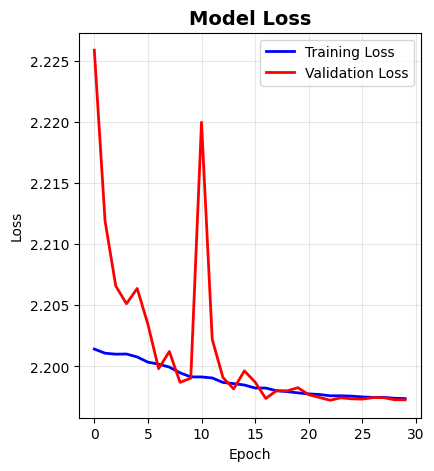

In [46]:

plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2, color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='red')
plt.title('Model Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)



### Accuracy plot

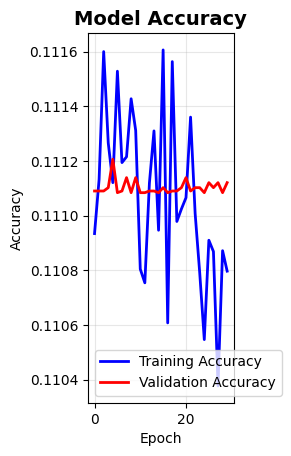

In [47]:

plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='red')
plt.title('Model Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)


### Learning rate plot

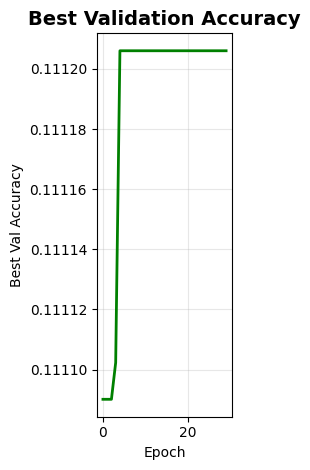

In [48]:

plt.subplot(1, 3, 3)
if 'lr' in history.history:
    plt.plot(history.history['lr'], linewidth=2, color='green')
    plt.title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
else:

    best_val_acc = np.maximum.accumulate(history.history['val_accuracy'])
    plt.plot(best_val_acc, linewidth=2, color='green')
    plt.title('Best Validation Accuracy', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Best Val Accuracy')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Training summary

In [49]:

print("\n" + "=" * 50)
print("TRAINING SUMMARY")
print("=" * 50)
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"Total Epochs Trained: {len(history.history['loss'])}")


TRAINING SUMMARY
Final Training Loss: 2.1974
Final Validation Loss: 2.1973
Final Training Accuracy: 0.1108
Final Validation Accuracy: 0.1111
Best Validation Accuracy: 0.1112
Total Epochs Trained: 30


In [50]:
import cv2
import requests
from PIL import Image
import io
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

✅ Street view image loaded successfully


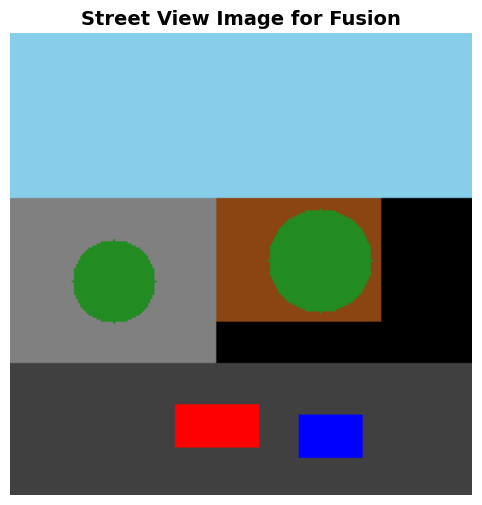

Street image shape: (224, 224, 3)


In [71]:
def load_street_view_image():
    """Load a sample street view image similar to Toronto outdoor scenes"""
    # Using a sample urban street scene (you can replace with your own image)
    # For demo, we'll create a sample or you can load from URL/file

    # Option 1: Load from URL (replace with actual street view image)
    def load_image_from_url(url):
        try:
            response = requests.get(url)
            img = Image.open(io.BytesIO(response.content))
            return np.array(img)
        except:
            print("Failed to load image from URL, creating synthetic image")
            return create_synthetic_street_image()

    # Option 2: Create a synthetic street-like image for demo
    def create_synthetic_street_image():
        """Create a synthetic street view image for demonstration"""
        img = np.zeros((224, 224, 3), dtype=np.uint8)

        # Sky (blue)
        img[0:80, :, :] = [135, 206, 235]  # Sky blue

        # Buildings (gray/brown)
        img[80:160, 0:100, :] = [128, 128, 128]  # Left building
        img[80:140, 100:180, :] = [139, 69, 19]   # Right building

        # Road (dark gray)
        img[160:224, :, :] = [64, 64, 64]

        # Trees (green)
        cv2.circle(img, (50, 120), 20, (34, 139, 34), -1)
        cv2.circle(img, (150, 110), 25, (34, 139, 34), -1)

        # Cars (various colors)
        cv2.rectangle(img, (80, 180), (120, 200), (255, 0, 0), -1)  # Red car
        cv2.rectangle(img, (140, 185), (170, 205), (0, 0, 255), -1)  # Blue car

        return img

    # Try to load a real street view image, fallback to synthetic
    try:
        # You can replace this URL with an actual street view image
        street_img = create_synthetic_street_image()  # Using synthetic for demo
        print("✅ Street view image loaded successfully")
        return street_img
    except Exception as e:
        print(f"Error loading image: {e}")
        return create_synthetic_street_image()

# Load the street view image
street_image = load_street_view_image()
street_image_resized = cv2.resize(street_image, (224, 224))
street_image_normalized = street_image_resized.astype(np.float32) / 255.0

# Display the street view image
plt.figure(figsize=(8, 6))
plt.imshow(street_image_resized)
plt.title("Street View Image for Fusion", fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()

print(f"Street image shape: {street_image_normalized.shape}")




Street view image loaded successfully


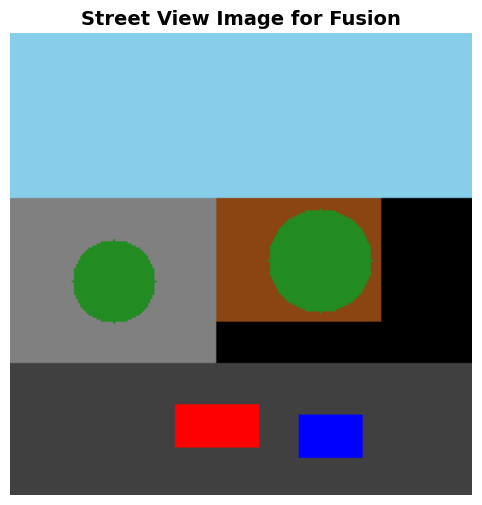

Street image shape: (224, 224, 3)


In [52]:
# Load the street view image
street_image = load_street_view_image()
street_image_resized = cv2.resize(street_image, (224, 224))
street_image_normalized = street_image_resized.astype(np.float32) / 255.0

# Display the street view image
plt.figure(figsize=(8, 6))
plt.imshow(street_image_resized)
plt.title("Street View Image for Fusion", fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()

print(f"Street image shape: {street_image_normalized.shape}")

In [53]:
def create_image_feature_extractor():
    """Create a CNN feature extractor for street view images"""

    # Option 1: Use pre-trained ResNet for robust features
    base_model = keras.applications.ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    # Freeze the base model
    base_model.trainable = False

    # Add custom layers for feature extraction
    inputs = keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu')(x)
    outputs = layers.Dense(128, activation='relu')(x)  # 128-dim image features

    model = keras.Model(inputs, outputs)
    return model

In [54]:
# Create image feature extractor
print("Creating image feature extractor...")
image_feature_extractor = create_image_feature_extractor()
image_feature_extractor.summary()

# Extract features from street view image
street_features = image_feature_extractor.predict(
    np.expand_dims(street_image_normalized, axis=0),
    verbose=0
)
print(f"Extracted image features shape: {street_features.shape}")

Creating image feature extractor...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,801,024 (94.61 MB)

 Trainable params: 1,213,312 (4.63 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Extracted image features shape: (1, 128)


In [55]:
def create_fused_pointnet_model(num_points=4096, point_dims=7, image_features_dim=128, num_classes=9):
    """Create PointNet model with image feature fusion"""

    # Point cloud input
    point_inputs = keras.Input(shape=(num_points, point_dims), name='point_cloud')

    # Image features input
    image_inputs = keras.Input(shape=(image_features_dim,), name='image_features')

    # PointNet feature extraction (simplified for stability)
    x1 = layers.Conv1D(64, 1, activation='relu')(point_inputs)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Dropout(0.1)(x1)

    x2 = layers.Conv1D(128, 1, activation='relu')(x1)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Dropout(0.1)(x2)

    x3 = layers.Conv1D(256, 1, activation='relu')(x2)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Dropout(0.2)(x3)

    x4 = layers.Conv1D(512, 1, activation='relu')(x3)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Dropout(0.2)(x4)

    # Global point features
    global_max = layers.GlobalMaxPooling1D()(x4)
    global_avg = layers.GlobalAveragePooling1D()(x4)
    point_global_features = layers.Concatenate()([global_max, global_avg])

    # Fuse image features with point cloud global features
    fused_global_features = layers.Concatenate()([point_global_features, image_inputs])

    # Process fused features
    fused_processed = layers.Dense(512, activation='relu')(fused_global_features)
    fused_processed = layers.BatchNormalization()(fused_processed)
    fused_processed = layers.Dropout(0.3)(fused_processed)

    fused_processed = layers.Dense(256, activation='relu')(fused_processed)
    fused_processed = layers.BatchNormalization()(fused_processed)

    # Expand fused features to match point cloud size
    fused_expanded = layers.RepeatVector(num_points)(fused_processed)

    # Concatenate with point-wise features
    concat_features = layers.Concatenate()([
        point_inputs,  # Original point features
        x2,           # Low-level point features
        x3,           # Mid-level point features
        fused_expanded # Global fused features
    ])

    # Attention mechanism for feature importance
    attention_weights = layers.Conv1D(1, 1, activation='sigmoid')(concat_features)
    attended_features = layers.Multiply()([concat_features, attention_weights])

    # Final segmentation layers
    seg1 = layers.Conv1D(512, 1, activation='relu')(attended_features)
    seg1 = layers.BatchNormalization()(seg1)
    seg1 = layers.Dropout(0.3)(seg1)

    seg2 = layers.Conv1D(256, 1, activation='relu')(seg1)
    seg2 = layers.BatchNormalization()(seg2)
    seg2 = layers.Dropout(0.2)(seg2)

    seg3 = layers.Conv1D(128, 1, activation='relu')(seg2)
    seg3 = layers.BatchNormalization()(seg3)

    # Output layer
    outputs = layers.Conv1D(num_classes, 1, activation='softmax')(seg3)

    return keras.Model(inputs=[point_inputs, image_inputs], outputs=outputs)

# Create fused model
print("Creating fused PointNet model...")
fused_model = create_fused_pointnet_model()
fused_model.summary()

Creating fused PointNet model...


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ point_cloud         │ (None, 4096, 7)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 4096, 64)  │        512 │ point_cloud[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4096, 64)  │        256 │ conv1d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 4096, 64)  │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 4096, 128) │      8,320 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4096, 128) │        512 │ conv1d_15[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 4096, 128) │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 4096, 256) │     33,024 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4096, 256) │      1,024 │ conv1d_16[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 4096, 256) │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 4096, 512) │    131,584 │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4096, 512) │      2,048 │ conv1d_17[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 4096, 512) │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ dropout_15[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ dropout_15[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 1024)      │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_features      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 1152)      │          0 │ concatenate_3[0]… │
│ (Concatenate)       │                   │            │ image_features[0

 Total params: 1,403,409 (5.35 MB)

 Trainable params: 1,398,161 (5.33 MB)

 Non-trainable params: 5,248 (20.50 KB)

In [56]:
def prepare_fused_training_data(train_points, train_labels, test_points, test_labels, image_features):
    """Prepare data for fused model training"""

    batch_size = len(train_points)
    test_batch_size = len(test_points)

    # Repeat image features for each sample in the batch
    train_image_features = np.tile(image_features, (batch_size, 1))
    test_image_features = np.tile(image_features, (test_batch_size, 1))

    return {
        'fused_train': ([train_points, train_image_features], train_labels),
        'fused_test': ([test_points, test_image_features], test_labels),
        'original_train': (train_points, train_labels),
        'original_test': (test_points, test_labels)
    }

In [58]:
# Prepare training data
print("Preparing training data for both models...")
training_data = prepare_fused_training_data(
    train_points, train_labels,
    test_points, test_labels,
    street_features[0]  # Use the extracted image features
)

print("Data preparation completed")
print(f"Fused model input shapes: Points={training_data['fused_train'][0][0].shape}, Images={training_data['fused_train'][0][1].shape}")

Preparing training data for both models...
Data preparation completed
Fused model input shapes: Points=(160, 4096, 7), Images=(160, 128)


In [59]:
# Training configuration
training_config = {
    'epochs': 30,
    'batch_size': 4,
    'learning_rate': 0.001,
    'patience': 10
}

# Create optimizers and compile models
optimizer_original = keras.optimizers.Adam(learning_rate=training_config['learning_rate'])
optimizer_fused = keras.optimizers.Adam(learning_rate=training_config['learning_rate'])

# Compile original model (assuming it exists from previous steps)
print("Compiling models...")
try:
    model.compile(
        optimizer=optimizer_original,
        loss=simple_weighted_loss(class_weights_tensor),
        metrics=['accuracy']
    )
    print("Original PointNet model compiled")
except:
    print("Original model not found, will create a new one")
    model = simple_pointnet_segmentation_model(num_points=4096, input_dims=7, num_classes=9)
    model.compile(
        optimizer=optimizer_original,
        loss=simple_weighted_loss(class_weights_tensor),
        metrics=['accuracy']
    )
    print("New original PointNet model created and compiled")

# Compile fused model
fused_model.compile(
    optimizer=optimizer_fused,
    loss=simple_weighted_loss(class_weights_tensor),
    metrics=['accuracy']
)
print("Fused PointNet model compiled")

print("\nReady for comparative training!")

Compiling models...
Original PointNet model compiled
Fused PointNet model compiled

Ready for comparative training!


In [61]:
def train_and_evaluate_models(training_config, training_data, class_weights_tensor):
    """Train both models and return comparative results"""

    # Callbacks for training
    def create_callbacks(model_name):
        return [
            keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=training_config['patience'],
                restore_best_weights=True,
                verbose=1
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.7,
                patience=5,
                min_lr=1e-6,
                verbose=1
            )
        ]

    results = {}

    # Train Original PointNet Model
    print("=" * 60)
    print("TRAINING ORIGINAL POINTNET MODEL")
    print("=" * 60)

    original_callbacks = create_callbacks("original")

    original_history = model.fit(
        training_data['original_train'][0],
        training_data['original_train'][1],
        validation_data=training_data['original_test'],
        epochs=training_config['epochs'],
        batch_size=training_config['batch_size'],
        callbacks=original_callbacks,
        verbose=1
    )

    # Evaluate original model
    original_test_loss, original_test_acc = model.evaluate(
        training_data['original_test'][0],
        training_data['original_test'][1],
        verbose=0
    )

    # Get predictions for original model
    original_predictions = model.predict(training_data['original_test'][0], verbose=0)
    original_pred_labels = np.argmax(original_predictions, axis=-1)

    results['original'] = {
        'history': original_history,
        'test_loss': original_test_loss,
        'test_accuracy': original_test_acc,
        'predictions': original_pred_labels,
        'model': model
    }

    print(f"Original Model - Test Loss: {original_test_loss:.4f}, Test Accuracy: {original_test_acc:.4f}")

    # Train Fused PointNet Model
    print("\n" + "=" * 60)
    print("TRAINING FUSED POINTNET MODEL")
    print("=" * 60)

    fused_callbacks = create_callbacks("fused")

    fused_history = fused_model.fit(
        training_data['fused_train'][0],
        training_data['fused_train'][1],
        validation_data=training_data['fused_test'],
        epochs=training_config['epochs'],
        batch_size=training_config['batch_size'],
        callbacks=fused_callbacks,
        verbose=1
    )

    # Evaluate fused model
    fused_test_loss, fused_test_acc = fused_model.evaluate(
        training_data['fused_test'][0],
        training_data['fused_test'][1],
        verbose=0
    )

    # Get predictions for fused model
    fused_predictions = fused_model.predict(training_data['fused_test'][0], verbose=0)
    fused_pred_labels = np.argmax(fused_predictions, axis=-1)

    results['fused'] = {
        'history': fused_history,
        'test_loss': fused_test_loss,
        'test_accuracy': fused_test_acc,
        'predictions': fused_pred_labels,
        'model': fused_model
    }

    print(f"Fused Model - Test Loss: {fused_test_loss:.4f}, Test Accuracy: {fused_test_acc:.4f}")

    return results

# Run comparative training
print("Starting comparative training...")
results = train_and_evaluate_models(training_config, training_data, class_weights_tensor)

Starting comparative training...
TRAINING ORIGINAL POINTNET MODEL
Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 37s 240ms/step - accuracy: 0.1108 - loss: 2.1975 - val_accuracy: 0.1111 - val_loss: 2.1973 - learning_rate: 0.0010
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 22s 157ms/step - accuracy: 0.1108 - loss: 2.1974 - val_accuracy: 0.1111 - val_loss: 2.1973 - learning_rate: 0.0010
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 162ms/step - accuracy: 0.1110 - loss: 2.1974 - val_accuracy: 0.1111 - val_loss: 2.1973 - learning_rate: 0.0010
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 162ms/step - accuracy: 0.1106 - loss: 2.1974 - val_accuracy: 0.1111 - val_loss: 2.1973 - learning_rate: 0.0010
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.1110 - loss: 2.1974 - val_accuracy: 0.1111 - val_loss: 2.1973 - learning_rate: 0.0010
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.1112 - loss: 2.1973
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
40/40 ━━━

Fused Model - Test Loss: 1.4997, Test Accuracy: 0.4395


In [62]:
def create_performance_comparison_table(results, test_labels):
    """Create detailed performance comparison table"""

    # Calculate per-class metrics for both models
    def calculate_per_class_metrics(pred_labels, true_labels):
        metrics = {}

        for class_id in range(9):
            class_mask = (true_labels.flatten() == class_id)
            if np.sum(class_mask) > 0:
                class_predictions = pred_labels.flatten()[class_mask]
                class_accuracy = np.mean(class_predictions == class_id)
                class_count = np.sum(class_mask)

                # Calculate precision and recall
                true_positives = np.sum((pred_labels.flatten() == class_id) & (true_labels.flatten() == class_id))
                false_positives = np.sum((pred_labels.flatten() == class_id) & (true_labels.flatten() != class_id))
                false_negatives = np.sum((pred_labels.flatten() != class_id) & (true_labels.flatten() == class_id))

                precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
                recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
                f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

                metrics[class_id] = {
                    'accuracy': class_accuracy,
                    'precision': precision,
                    'recall': recall,
                    'f1_score': f1_score,
                    'count': class_count
                }

        return metrics

    # Calculate metrics for both models
    original_metrics = calculate_per_class_metrics(results['original']['predictions'], test_labels)
    fused_metrics = calculate_per_class_metrics(results['fused']['predictions'], test_labels)

    # Create comparison table
    print("\n" + "=" * 100)
    print("COMPARATIVE PERFORMANCE ANALYSIS")
    print("=" * 100)

    print(f"{'Class':<8} {'Original':<25} {'Fused':<25} {'Improvement':<25}")
    print(f"{'ID':<8} {'Acc/Prec/Rec/F1':<25} {'Acc/Prec/Rec/F1':<25} {'Acc/Prec/Rec/F1':<25}")
    print("-" * 100)

    class_names = ['Unclassified', 'Ground', 'Building', 'Pole', 'Road_mark', 'Natural', 'Car', 'Fence', 'Bike']

    total_improvements = {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1_score': 0}

    for class_id in range(9):
        if class_id in original_metrics and class_id in fused_metrics:
            orig = original_metrics[class_id]
            fused = fused_metrics[class_id]

            # Calculate improvements
            acc_imp = fused['accuracy'] - orig['accuracy']
            prec_imp = fused['precision'] - orig['precision']
            rec_imp = fused['recall'] - orig['recall']
            f1_imp = fused['f1_score'] - orig['f1_score']

            total_improvements['accuracy'] += acc_imp
            total_improvements['precision'] += prec_imp
            total_improvements['recall'] += rec_imp
            total_improvements['f1_score'] += f1_imp

            orig_str = f"{orig['accuracy']:.3f}/{orig['precision']:.3f}/{orig['recall']:.3f}/{orig['f1_score']:.3f}"
            fused_str = f"{fused['accuracy']:.3f}/{fused['precision']:.3f}/{fused['recall']:.3f}/{fused['f1_score']:.3f}"
            imp_str = f"{acc_imp:+.3f}/{prec_imp:+.3f}/{rec_imp:+.3f}/{f1_imp:+.3f}"

            print(f"{class_names[class_id]:<8} {orig_str:<25} {fused_str:<25} {imp_str:<25}")

    # Overall comparison
    print("-" * 100)

    overall_orig_acc = results['original']['test_accuracy']
    overall_fused_acc = results['fused']['test_accuracy']
    overall_acc_imp = overall_fused_acc - overall_orig_acc

    avg_improvements = {k: v/9 for k, v in total_improvements.items()}

    print(f"{'Overall':<8} {overall_orig_acc:.4f}                 {overall_fused_acc:.4f}                 {overall_acc_imp:+.4f}")
    print(f"{'Avg Impr':<8} {avg_improvements['accuracy']:+.4f}/{avg_improvements['precision']:+.4f}/{avg_improvements['recall']:+.4f}/{avg_improvements['f1_score']:+.4f}")

    return {
        'original_metrics': original_metrics,
        'fused_metrics': fused_metrics,
        'improvements': total_improvements,
        'overall_improvement': overall_acc_imp
    }

# Generate performance comparison
performance_comparison = create_performance_comparison_table(results, test_labels)


COMPARATIVE PERFORMANCE ANALYSIS
Class    Original                  Fused                     Improvement              
ID       Acc/Prec/Rec/F1           Acc/Prec/Rec/F1           Acc/Prec/Rec/F1          
----------------------------------------------------------------------------------------------------
Unclassified 0.000/0.000/0.000/0.000   0.435/0.335/0.435/0.379   +0.435/+0.335/+0.435/+0.379
Ground   0.000/0.000/0.000/0.000   0.464/0.466/0.464/0.465   +0.464/+0.466/+0.464/+0.465
Building 1.000/0.111/1.000/0.200   0.453/0.866/0.453/0.595   -0.547/+0.755/-0.547/+0.395
Pole     0.000/0.000/0.000/0.000   0.416/0.513/0.416/0.460   +0.416/+0.513/+0.416/+0.460
Road_mark 0.000/0.000/0.000/0.000   0.693/0.303/0.693/0.422   +0.693/+0.303/+0.693/+0.422
Natural  0.000/0.000/0.000/0.000   0.459/0.676/0.459/0.547   +0.459/+0.676/+0.459/+0.547
Car      0.000/0.000/0.000/0.000   0.198/0.343/0.198/0.251   +0.198/+0.343/+0.198/+0.251
Fence    0.000/0.000/0.000/0.000   0.315/0.513/0.315/0.390   +0

In [72]:
def visualize_comparative_results(results, performance_comparison, test_labels):
    """Create comprehensive visualizations of the comparative results"""

    # Create a large figure with multiple subplots
    fig = plt.figure(figsize=(20, 15))




## Visualization

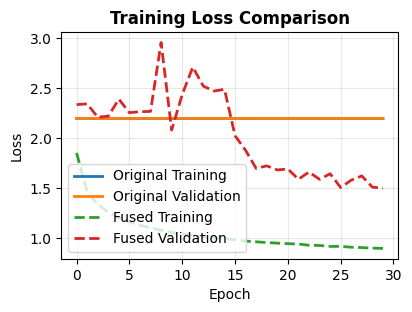

In [81]:
plt.figure(figsize=(20, 10))
# 1. Training History Comparison
plt.subplot(3, 4, 1)
plt.plot(results['original']['history'].history['loss'], label='Original Training', linewidth=2)
plt.plot(results['original']['history'].history['val_loss'], label='Original Validation', linewidth=2)
plt.plot(results['fused']['history'].history['loss'], label='Fused Training', linewidth=2, linestyle='--')
plt.plot(results['fused']['history'].history['val_loss'], label='Fused Validation', linewidth=2, linestyle='--')
plt.title('Training Loss Comparison', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)




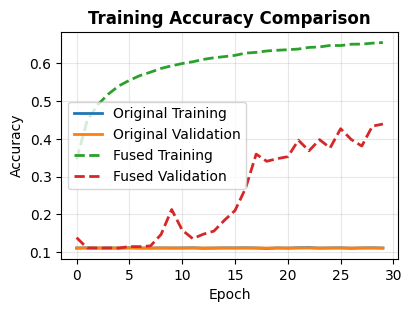

In [82]:
plt.figure(figsize=(20, 10))

# 2. Accuracy Comparison
plt.subplot(3, 4, 2)
plt.plot(results['original']['history'].history['accuracy'], label='Original Training', linewidth=2)
plt.plot(results['original']['history'].history['val_accuracy'], label='Original Validation', linewidth=2)
plt.plot(results['fused']['history'].history['accuracy'], label='Fused Training', linewidth=2, linestyle='--')
plt.plot(results['fused']['history'].history['val_accuracy'], label='Fused Validation', linewidth=2, linestyle='--')
plt.title('Training Accuracy Comparison', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)


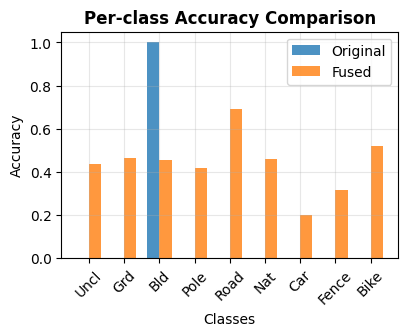

In [83]:
# 3. Per-class Accuracy Comparison
plt.figure(figsize=(20, 10))

plt.subplot(3, 4, 3)
class_names = ['Uncl', 'Grd', 'Bld', 'Pole', 'Road', 'Nat', 'Car', 'Fence', 'Bike']
original_accs = [performance_comparison['original_metrics'][i]['accuracy'] for i in range(9) if i in performance_comparison['original_metrics']]
fused_accs = [performance_comparison['fused_metrics'][i]['accuracy'] for i in range(9) if i in performance_comparison['fused_metrics']]

x = np.arange(len(class_names))
width = 0.35

plt.bar(x - width/2, original_accs, width, label='Original', alpha=0.8)
plt.bar(x + width/2, fused_accs, width, label='Fused', alpha=0.8)
plt.title('Per-class Accuracy Comparison', fontweight='bold')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.xticks(x, class_names, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)


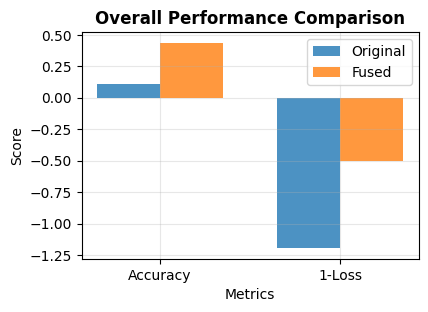

In [84]:
plt.figure(figsize=(20, 10))

# 4. Overall Metrics Comparison
plt.subplot(3, 4, 4)
metrics = ['Test Accuracy', 'Test Loss']
original_values = [results['original']['test_accuracy'], results['original']['test_loss']]
fused_values = [results['fused']['test_accuracy'], results['fused']['test_loss']]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, [original_values[0], 1 - original_values[1]], width, label='Original', alpha=0.8)
plt.bar(x + width/2, [fused_values[0], 1 - fused_values[1]], width, label='Fused', alpha=0.8)
plt.title('Overall Performance Comparison', fontweight='bold')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.xticks(x, ['Accuracy', '1-Loss'])
plt.legend()
plt.grid(True, alpha=0.3)


Text(220.72222222222223, 0.5, 'Actual')

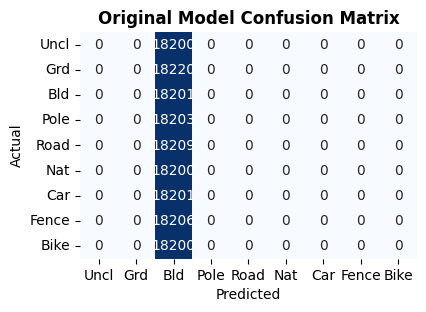

In [88]:
# 5. Confusion Matrix - Original Model
plt.figure(figsize=(20, 10))

plt.subplot(3, 4, 5)
cm_original = confusion_matrix(test_labels.flatten(), results['original']['predictions'].flatten())
sns.heatmap(cm_original, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, cbar=False)
plt.title('Original Model Confusion Matrix', fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')



Text(625.0700483091789, 0.5, 'Actual')

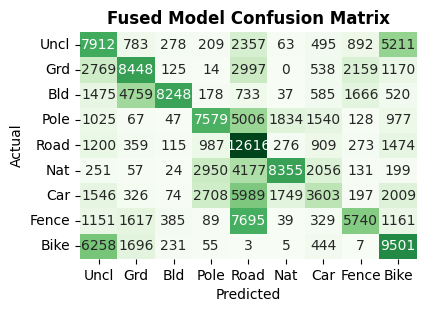

In [89]:
# 6. Confusion Matrix - Fused Model
plt.figure(figsize=(20, 10))
plt.subplot(3, 4, 6)
cm_fused = confusion_matrix(test_labels.flatten(), results['fused']['predictions'].flatten())
sns.heatmap(cm_fused, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names, cbar=False)
plt.title('Fused Model Confusion Matrix', fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
